In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 23 12:22:38 2023

@author: vishalr
"""
import numpy as np
import pandas as pd
import pickle


#change this to the folder where you store your data
data_dir = "./"

#each of the two data frames below have 20,000 rows, each corresponding to one sample from the original graph
#each sample consists of 21 nodes; node_labels contains the names of these 21 nodes of the form Vxyz
#each node is a DNA fragment of length 500 bases; so Vxyz coveres region [500*xyz, 500*xyz+500)
#adjacency_matrix has the flattended adjacecny matrix for each of these 20,000 samples
#so each row is of dimension 21*21 = 441


#node_labels = pd.read_pickle(data_dir+'df_chr2L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot_sample_node_matrix')

#adjacency_matrix = pd.read_pickle(data_dir+'df_chr2L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot')

node_labels_chr2L = np.load(data_dir + 'df_chr2L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot_sample_node_matrix.npy')
adjacency_matrix_chr2L = np.load(data_dir + 'df_chr2L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot.npy')

node_labels_chr2R = np.load(data_dir + 'df_chr2R_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot_sample_node_matrix.npy')
adjacency_matrix_chr2R = np.load(data_dir + 'df_chr2R_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot.npy')

node_labels_chr3L = np.load(data_dir + 'df_chr3L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot_sample_node_matrix.npy')
adjacency_matrix_chr3L = np.load(data_dir + 'df_chr3L_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot.npy')

node_labels_chr3R = np.load(data_dir + 'df_chr3R_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot_sample_node_matrix.npy')
adjacency_matrix_chr3R = np.load(data_dir + 'df_chr3R_drosophila_ChIA_Drop_0.1_PASS_20000_MCMC_pivot.npy')

#just seeing the size of input; doesn't really do anything
print("chr2L node labels shape:", node_labels_chr2L.shape)
print("chr2L adjacency matrix shape:", adjacency_matrix_chr2L.shape)
print("chr2R node labels shape:", node_labels_chr2R.shape)
print("chr2R adjacency matrix shape:", adjacency_matrix_chr2R.shape)
print("chr3L node labels shape:", node_labels_chr3L.shape)
print("chr3L adjacency matrix shape:", adjacency_matrix_chr3L.shape)
print("chr3R node labels shape:", node_labels_chr3R.shape)
print("chr3R adjacency matrix shape:", adjacency_matrix_chr3R.shape)

chr2L node labels shape: (20000, 21)
chr2L adjacency matrix shape: (20000, 442)
chr2R node labels shape: (20000, 21)
chr2R adjacency matrix shape: (20000, 442)
chr3L node labels shape: (20000, 21)
chr3L adjacency matrix shape: (20000, 442)
chr3R node labels shape: (20000, 21)
chr3R adjacency matrix shape: (20000, 442)


In [2]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# trying print the shape of the loaded array to get the number of samples
print(f'Number of samples: {adjacency_matrix_chr2L.shape[0]}')

Number of samples: 20000


In [20]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
import scipy.sparse as sp
from torch_geometric.utils import from_scipy_sparse_matrix

def create_graph_data(adjacency_matrix, node_labels, label_number):
    graphs = []

    for i in range(adjacency_matrix.shape[0]):
        row = adjacency_matrix[i]
        labels = node_labels[i]
        
        assert len(row) == 21 * 21 + 1, f"Each row should have 21*21 + 1 elements, but got {len(row)} elements."

        row = row[:-1]  

        assert len(row) == 21 * 21, f"Each row should have 21*21 elements after removing -1 column, but got {len(row)} elements."
        
        adj_matrix = row.reshape((21, 21))
        
        edge_index = np.vstack(np.nonzero(adj_matrix)).astype(np.int64)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        
        x = torch.tensor(labels, dtype=torch.float).view(-1, 1)
        
        y = torch.tensor([label_number], dtype=torch.long)
        
        graph_data = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph_data)
    
    return graphs

worklist_node_labels = []
worklist_adjacency_matrix = []

#concatinate things  together
worklist_node_labels.append(node_labels_chr2L)
worklist_node_labels.append(node_labels_chr2R)
worklist_node_labels.append(node_labels_chr3L)
worklist_node_labels.append(node_labels_chr3R)
worklist_adjacency_matrix.append(adjacency_matrix_chr2L)
worklist_adjacency_matrix.append(adjacency_matrix_chr2R)
worklist_adjacency_matrix.append(adjacency_matrix_chr3L)
worklist_adjacency_matrix.append(adjacency_matrix_chr3R)

dataset = []
for label_number in range(len(worklist_adjacency_matrix)):
    adj_matrix = worklist_adjacency_matrix[label_number]
    node_labels = worklist_node_labels[label_number]
    graphs = create_graph_data(adj_matrix, node_labels, label_number)
    dataset.extend(graphs)

train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 64000 graphs
Validation set = 8000 graphs
Test set       = 8000 graphs

Train loader:
 - Subgraph 0: DataBatch(x=[1344, 1], edge_index=[2, 4632], y=[64], batch=[1344], ptr=[65])
 - Subgraph 1: DataBatch(x=[1344, 1], edge_index=[2, 4688], y=[64], batch=[1344], ptr=[65])
 - Subgraph 2: DataBatch(x=[1344, 1], edge_index=[2, 4668], y=[64], batch=[1344], ptr=[65])
 - Subgraph 3: DataBatch(x=[1344, 1], edge_index=[2, 4590], y=[64], batch=[1344], ptr=[65])
 - Subgraph 4: DataBatch(x=[1344, 1], edge_index=[2, 4578], y=[64], batch=[1344], ptr=[65])
 - Subgraph 5: DataBatch(x=[1344, 1], edge_index=[2, 4600], y=[64], batch=[1344], ptr=[65])
 - Subgraph 6: DataBatch(x=[1344, 1], edge_index=[2, 4830], y=[64], batch=[1344], ptr=[65])
 - Subgraph 7: DataBatch(x=[1344, 1], edge_index=[2, 4548], y=[64], batch=[1344], ptr=[65])
 - Subgraph 8: DataBatch(x=[1344, 1], edge_index=[2, 4590], y=[64], batch=[1344], ptr=[65])
 - Subgraph 9: DataBatch(x=[1344, 1], edge_index=[2, 4628], y=[64], b

 - Subgraph 94: DataBatch(x=[1344, 1], edge_index=[2, 4482], y=[64], batch=[1344], ptr=[65])
 - Subgraph 95: DataBatch(x=[1344, 1], edge_index=[2, 4860], y=[64], batch=[1344], ptr=[65])
 - Subgraph 96: DataBatch(x=[1344, 1], edge_index=[2, 4722], y=[64], batch=[1344], ptr=[65])
 - Subgraph 97: DataBatch(x=[1344, 1], edge_index=[2, 5010], y=[64], batch=[1344], ptr=[65])
 - Subgraph 98: DataBatch(x=[1344, 1], edge_index=[2, 4666], y=[64], batch=[1344], ptr=[65])
 - Subgraph 99: DataBatch(x=[1344, 1], edge_index=[2, 4626], y=[64], batch=[1344], ptr=[65])
 - Subgraph 100: DataBatch(x=[1344, 1], edge_index=[2, 4612], y=[64], batch=[1344], ptr=[65])
 - Subgraph 101: DataBatch(x=[1344, 1], edge_index=[2, 4572], y=[64], batch=[1344], ptr=[65])
 - Subgraph 102: DataBatch(x=[1344, 1], edge_index=[2, 4658], y=[64], batch=[1344], ptr=[65])
 - Subgraph 103: DataBatch(x=[1344, 1], edge_index=[2, 4742], y=[64], batch=[1344], ptr=[65])
 - Subgraph 104: DataBatch(x=[1344, 1], edge_index=[2, 4426], y=[6

 - Subgraph 201: DataBatch(x=[1344, 1], edge_index=[2, 4538], y=[64], batch=[1344], ptr=[65])
 - Subgraph 202: DataBatch(x=[1344, 1], edge_index=[2, 4628], y=[64], batch=[1344], ptr=[65])
 - Subgraph 203: DataBatch(x=[1344, 1], edge_index=[2, 4646], y=[64], batch=[1344], ptr=[65])
 - Subgraph 204: DataBatch(x=[1344, 1], edge_index=[2, 4316], y=[64], batch=[1344], ptr=[65])
 - Subgraph 205: DataBatch(x=[1344, 1], edge_index=[2, 4468], y=[64], batch=[1344], ptr=[65])
 - Subgraph 206: DataBatch(x=[1344, 1], edge_index=[2, 4484], y=[64], batch=[1344], ptr=[65])
 - Subgraph 207: DataBatch(x=[1344, 1], edge_index=[2, 4774], y=[64], batch=[1344], ptr=[65])
 - Subgraph 208: DataBatch(x=[1344, 1], edge_index=[2, 4704], y=[64], batch=[1344], ptr=[65])
 - Subgraph 209: DataBatch(x=[1344, 1], edge_index=[2, 4852], y=[64], batch=[1344], ptr=[65])
 - Subgraph 210: DataBatch(x=[1344, 1], edge_index=[2, 4238], y=[64], batch=[1344], ptr=[65])
 - Subgraph 211: DataBatch(x=[1344, 1], edge_index=[2, 4458]

 - Subgraph 312: DataBatch(x=[1344, 1], edge_index=[2, 4454], y=[64], batch=[1344], ptr=[65])
 - Subgraph 313: DataBatch(x=[1344, 1], edge_index=[2, 4580], y=[64], batch=[1344], ptr=[65])
 - Subgraph 314: DataBatch(x=[1344, 1], edge_index=[2, 4624], y=[64], batch=[1344], ptr=[65])
 - Subgraph 315: DataBatch(x=[1344, 1], edge_index=[2, 4770], y=[64], batch=[1344], ptr=[65])
 - Subgraph 316: DataBatch(x=[1344, 1], edge_index=[2, 4392], y=[64], batch=[1344], ptr=[65])
 - Subgraph 317: DataBatch(x=[1344, 1], edge_index=[2, 4434], y=[64], batch=[1344], ptr=[65])
 - Subgraph 318: DataBatch(x=[1344, 1], edge_index=[2, 4368], y=[64], batch=[1344], ptr=[65])
 - Subgraph 319: DataBatch(x=[1344, 1], edge_index=[2, 4392], y=[64], batch=[1344], ptr=[65])
 - Subgraph 320: DataBatch(x=[1344, 1], edge_index=[2, 4498], y=[64], batch=[1344], ptr=[65])
 - Subgraph 321: DataBatch(x=[1344, 1], edge_index=[2, 4786], y=[64], batch=[1344], ptr=[65])
 - Subgraph 322: DataBatch(x=[1344, 1], edge_index=[2, 4454]

 - Subgraph 411: DataBatch(x=[1344, 1], edge_index=[2, 4420], y=[64], batch=[1344], ptr=[65])
 - Subgraph 412: DataBatch(x=[1344, 1], edge_index=[2, 4562], y=[64], batch=[1344], ptr=[65])
 - Subgraph 413: DataBatch(x=[1344, 1], edge_index=[2, 4588], y=[64], batch=[1344], ptr=[65])
 - Subgraph 414: DataBatch(x=[1344, 1], edge_index=[2, 4748], y=[64], batch=[1344], ptr=[65])
 - Subgraph 415: DataBatch(x=[1344, 1], edge_index=[2, 4468], y=[64], batch=[1344], ptr=[65])
 - Subgraph 416: DataBatch(x=[1344, 1], edge_index=[2, 4484], y=[64], batch=[1344], ptr=[65])
 - Subgraph 417: DataBatch(x=[1344, 1], edge_index=[2, 4456], y=[64], batch=[1344], ptr=[65])
 - Subgraph 418: DataBatch(x=[1344, 1], edge_index=[2, 5086], y=[64], batch=[1344], ptr=[65])
 - Subgraph 419: DataBatch(x=[1344, 1], edge_index=[2, 4798], y=[64], batch=[1344], ptr=[65])
 - Subgraph 420: DataBatch(x=[1344, 1], edge_index=[2, 4694], y=[64], batch=[1344], ptr=[65])
 - Subgraph 421: DataBatch(x=[1344, 1], edge_index=[2, 4620]

 - Subgraph 514: DataBatch(x=[1344, 1], edge_index=[2, 4628], y=[64], batch=[1344], ptr=[65])
 - Subgraph 515: DataBatch(x=[1344, 1], edge_index=[2, 5064], y=[64], batch=[1344], ptr=[65])
 - Subgraph 516: DataBatch(x=[1344, 1], edge_index=[2, 4722], y=[64], batch=[1344], ptr=[65])
 - Subgraph 517: DataBatch(x=[1344, 1], edge_index=[2, 4642], y=[64], batch=[1344], ptr=[65])
 - Subgraph 518: DataBatch(x=[1344, 1], edge_index=[2, 4256], y=[64], batch=[1344], ptr=[65])
 - Subgraph 519: DataBatch(x=[1344, 1], edge_index=[2, 4582], y=[64], batch=[1344], ptr=[65])
 - Subgraph 520: DataBatch(x=[1344, 1], edge_index=[2, 4552], y=[64], batch=[1344], ptr=[65])
 - Subgraph 521: DataBatch(x=[1344, 1], edge_index=[2, 4682], y=[64], batch=[1344], ptr=[65])
 - Subgraph 522: DataBatch(x=[1344, 1], edge_index=[2, 4678], y=[64], batch=[1344], ptr=[65])
 - Subgraph 523: DataBatch(x=[1344, 1], edge_index=[2, 4542], y=[64], batch=[1344], ptr=[65])
 - Subgraph 524: DataBatch(x=[1344, 1], edge_index=[2, 4676]

 - Subgraph 608: DataBatch(x=[1344, 1], edge_index=[2, 4666], y=[64], batch=[1344], ptr=[65])
 - Subgraph 609: DataBatch(x=[1344, 1], edge_index=[2, 4440], y=[64], batch=[1344], ptr=[65])
 - Subgraph 610: DataBatch(x=[1344, 1], edge_index=[2, 4464], y=[64], batch=[1344], ptr=[65])
 - Subgraph 611: DataBatch(x=[1344, 1], edge_index=[2, 4544], y=[64], batch=[1344], ptr=[65])
 - Subgraph 612: DataBatch(x=[1344, 1], edge_index=[2, 4662], y=[64], batch=[1344], ptr=[65])
 - Subgraph 613: DataBatch(x=[1344, 1], edge_index=[2, 4738], y=[64], batch=[1344], ptr=[65])
 - Subgraph 614: DataBatch(x=[1344, 1], edge_index=[2, 4548], y=[64], batch=[1344], ptr=[65])
 - Subgraph 615: DataBatch(x=[1344, 1], edge_index=[2, 4736], y=[64], batch=[1344], ptr=[65])
 - Subgraph 616: DataBatch(x=[1344, 1], edge_index=[2, 4560], y=[64], batch=[1344], ptr=[65])
 - Subgraph 617: DataBatch(x=[1344, 1], edge_index=[2, 4794], y=[64], batch=[1344], ptr=[65])
 - Subgraph 618: DataBatch(x=[1344, 1], edge_index=[2, 4670]

 - Subgraph 709: DataBatch(x=[1344, 1], edge_index=[2, 4884], y=[64], batch=[1344], ptr=[65])
 - Subgraph 710: DataBatch(x=[1344, 1], edge_index=[2, 4844], y=[64], batch=[1344], ptr=[65])
 - Subgraph 711: DataBatch(x=[1344, 1], edge_index=[2, 4634], y=[64], batch=[1344], ptr=[65])
 - Subgraph 712: DataBatch(x=[1344, 1], edge_index=[2, 4574], y=[64], batch=[1344], ptr=[65])
 - Subgraph 713: DataBatch(x=[1344, 1], edge_index=[2, 4546], y=[64], batch=[1344], ptr=[65])
 - Subgraph 714: DataBatch(x=[1344, 1], edge_index=[2, 4728], y=[64], batch=[1344], ptr=[65])
 - Subgraph 715: DataBatch(x=[1344, 1], edge_index=[2, 4602], y=[64], batch=[1344], ptr=[65])
 - Subgraph 716: DataBatch(x=[1344, 1], edge_index=[2, 4536], y=[64], batch=[1344], ptr=[65])
 - Subgraph 717: DataBatch(x=[1344, 1], edge_index=[2, 4838], y=[64], batch=[1344], ptr=[65])
 - Subgraph 718: DataBatch(x=[1344, 1], edge_index=[2, 4802], y=[64], batch=[1344], ptr=[65])
 - Subgraph 719: DataBatch(x=[1344, 1], edge_index=[2, 4746]

 - Subgraph 878: DataBatch(x=[1344, 1], edge_index=[2, 4446], y=[64], batch=[1344], ptr=[65])
 - Subgraph 879: DataBatch(x=[1344, 1], edge_index=[2, 4290], y=[64], batch=[1344], ptr=[65])
 - Subgraph 880: DataBatch(x=[1344, 1], edge_index=[2, 4622], y=[64], batch=[1344], ptr=[65])
 - Subgraph 881: DataBatch(x=[1344, 1], edge_index=[2, 4758], y=[64], batch=[1344], ptr=[65])
 - Subgraph 882: DataBatch(x=[1344, 1], edge_index=[2, 4528], y=[64], batch=[1344], ptr=[65])
 - Subgraph 883: DataBatch(x=[1344, 1], edge_index=[2, 4432], y=[64], batch=[1344], ptr=[65])
 - Subgraph 884: DataBatch(x=[1344, 1], edge_index=[2, 4538], y=[64], batch=[1344], ptr=[65])
 - Subgraph 885: DataBatch(x=[1344, 1], edge_index=[2, 4422], y=[64], batch=[1344], ptr=[65])
 - Subgraph 886: DataBatch(x=[1344, 1], edge_index=[2, 4622], y=[64], batch=[1344], ptr=[65])
 - Subgraph 887: DataBatch(x=[1344, 1], edge_index=[2, 4382], y=[64], batch=[1344], ptr=[65])
 - Subgraph 888: DataBatch(x=[1344, 1], edge_index=[2, 4560]

 - Subgraph 36: DataBatch(x=[1344, 1], edge_index=[2, 4694], y=[64], batch=[1344], ptr=[65])
 - Subgraph 37: DataBatch(x=[1344, 1], edge_index=[2, 4730], y=[64], batch=[1344], ptr=[65])
 - Subgraph 38: DataBatch(x=[1344, 1], edge_index=[2, 4392], y=[64], batch=[1344], ptr=[65])
 - Subgraph 39: DataBatch(x=[1344, 1], edge_index=[2, 4530], y=[64], batch=[1344], ptr=[65])
 - Subgraph 40: DataBatch(x=[1344, 1], edge_index=[2, 4784], y=[64], batch=[1344], ptr=[65])
 - Subgraph 41: DataBatch(x=[1344, 1], edge_index=[2, 4406], y=[64], batch=[1344], ptr=[65])
 - Subgraph 42: DataBatch(x=[1344, 1], edge_index=[2, 4576], y=[64], batch=[1344], ptr=[65])
 - Subgraph 43: DataBatch(x=[1344, 1], edge_index=[2, 4588], y=[64], batch=[1344], ptr=[65])
 - Subgraph 44: DataBatch(x=[1344, 1], edge_index=[2, 4754], y=[64], batch=[1344], ptr=[65])
 - Subgraph 45: DataBatch(x=[1344, 1], edge_index=[2, 4502], y=[64], batch=[1344], ptr=[65])
 - Subgraph 46: DataBatch(x=[1344, 1], edge_index=[2, 4500], y=[64], b

 - Subgraph 11: DataBatch(x=[1344, 1], edge_index=[2, 4196], y=[64], batch=[1344], ptr=[65])
 - Subgraph 12: DataBatch(x=[1344, 1], edge_index=[2, 4526], y=[64], batch=[1344], ptr=[65])
 - Subgraph 13: DataBatch(x=[1344, 1], edge_index=[2, 4742], y=[64], batch=[1344], ptr=[65])
 - Subgraph 14: DataBatch(x=[1344, 1], edge_index=[2, 4774], y=[64], batch=[1344], ptr=[65])
 - Subgraph 15: DataBatch(x=[1344, 1], edge_index=[2, 4606], y=[64], batch=[1344], ptr=[65])
 - Subgraph 16: DataBatch(x=[1344, 1], edge_index=[2, 4770], y=[64], batch=[1344], ptr=[65])
 - Subgraph 17: DataBatch(x=[1344, 1], edge_index=[2, 4562], y=[64], batch=[1344], ptr=[65])
 - Subgraph 18: DataBatch(x=[1344, 1], edge_index=[2, 4708], y=[64], batch=[1344], ptr=[65])
 - Subgraph 19: DataBatch(x=[1344, 1], edge_index=[2, 4614], y=[64], batch=[1344], ptr=[65])
 - Subgraph 20: DataBatch(x=[1344, 1], edge_index=[2, 4708], y=[64], batch=[1344], ptr=[65])
 - Subgraph 21: DataBatch(x=[1344, 1], edge_index=[2, 4300], y=[64], b

 - Subgraph 106: DataBatch(x=[1344, 1], edge_index=[2, 4626], y=[64], batch=[1344], ptr=[65])
 - Subgraph 107: DataBatch(x=[1344, 1], edge_index=[2, 4616], y=[64], batch=[1344], ptr=[65])
 - Subgraph 108: DataBatch(x=[1344, 1], edge_index=[2, 4784], y=[64], batch=[1344], ptr=[65])
 - Subgraph 109: DataBatch(x=[1344, 1], edge_index=[2, 4442], y=[64], batch=[1344], ptr=[65])
 - Subgraph 110: DataBatch(x=[1344, 1], edge_index=[2, 4414], y=[64], batch=[1344], ptr=[65])
 - Subgraph 111: DataBatch(x=[1344, 1], edge_index=[2, 4656], y=[64], batch=[1344], ptr=[65])
 - Subgraph 112: DataBatch(x=[1344, 1], edge_index=[2, 4664], y=[64], batch=[1344], ptr=[65])
 - Subgraph 113: DataBatch(x=[1344, 1], edge_index=[2, 4500], y=[64], batch=[1344], ptr=[65])
 - Subgraph 114: DataBatch(x=[1344, 1], edge_index=[2, 4614], y=[64], batch=[1344], ptr=[65])
 - Subgraph 115: DataBatch(x=[1344, 1], edge_index=[2, 4542], y=[64], batch=[1344], ptr=[65])
 - Subgraph 116: DataBatch(x=[1344, 1], edge_index=[2, 4618]

In [43]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, num_node_features, num_classes, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h, F.log_softmax(h, dim=1)

gin = GIN(num_node_features=num_node_features, num_classes=num_classes, dim_h=32)

num_node_features = dataset[0].num_features
num_classes = len(set([data.y.item() for data in dataset if data.y is not None]))

class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, num_node_features, num_classes, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        hG = global_mean_pool(h, batch)

        # Classifier
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)
        
        return hG, F.log_softmax(h, dim=1)
    
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
    epochs = 3

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Train on batches
        for data in loader:
            optimizer.zero_grad()
            _, out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            val_loss, val_acc = test(model, val_loader)

        # Print metrics every 10 epochs
        if(epoch % 1 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                  f'| Train Acc: {acc*100:>5.2f}% '
                  f'| Val Loss: {val_loss:.2f} '
                  f'| Val Acc: {val_acc*100:.2f}%')
          
    test_loss, test_acc = test(model, test_loader)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = GCN(num_node_features=num_node_features, num_classes=num_classes, dim_h=32)
gcn = train(gcn, train_loader)
gin = GIN(num_node_features=num_node_features, num_classes=num_classes, dim_h=32)
gin = train(gin, train_loader)


Epoch   0 | Train Loss: 13.37 | Train Acc: 31.18% | Val Loss: 2.70 | Val Acc: 0.00%
Test Loss: 2.74 | Test Acc: 0.00%
Epoch   0 | Train Loss: 1.18 | Train Acc: 43.48% | Val Loss: 1.89 | Val Acc: 20.04%
Test Loss: 2.69 | Test Acc: 3.38%


ValueError: index 16 is out of bounds for array with size 16

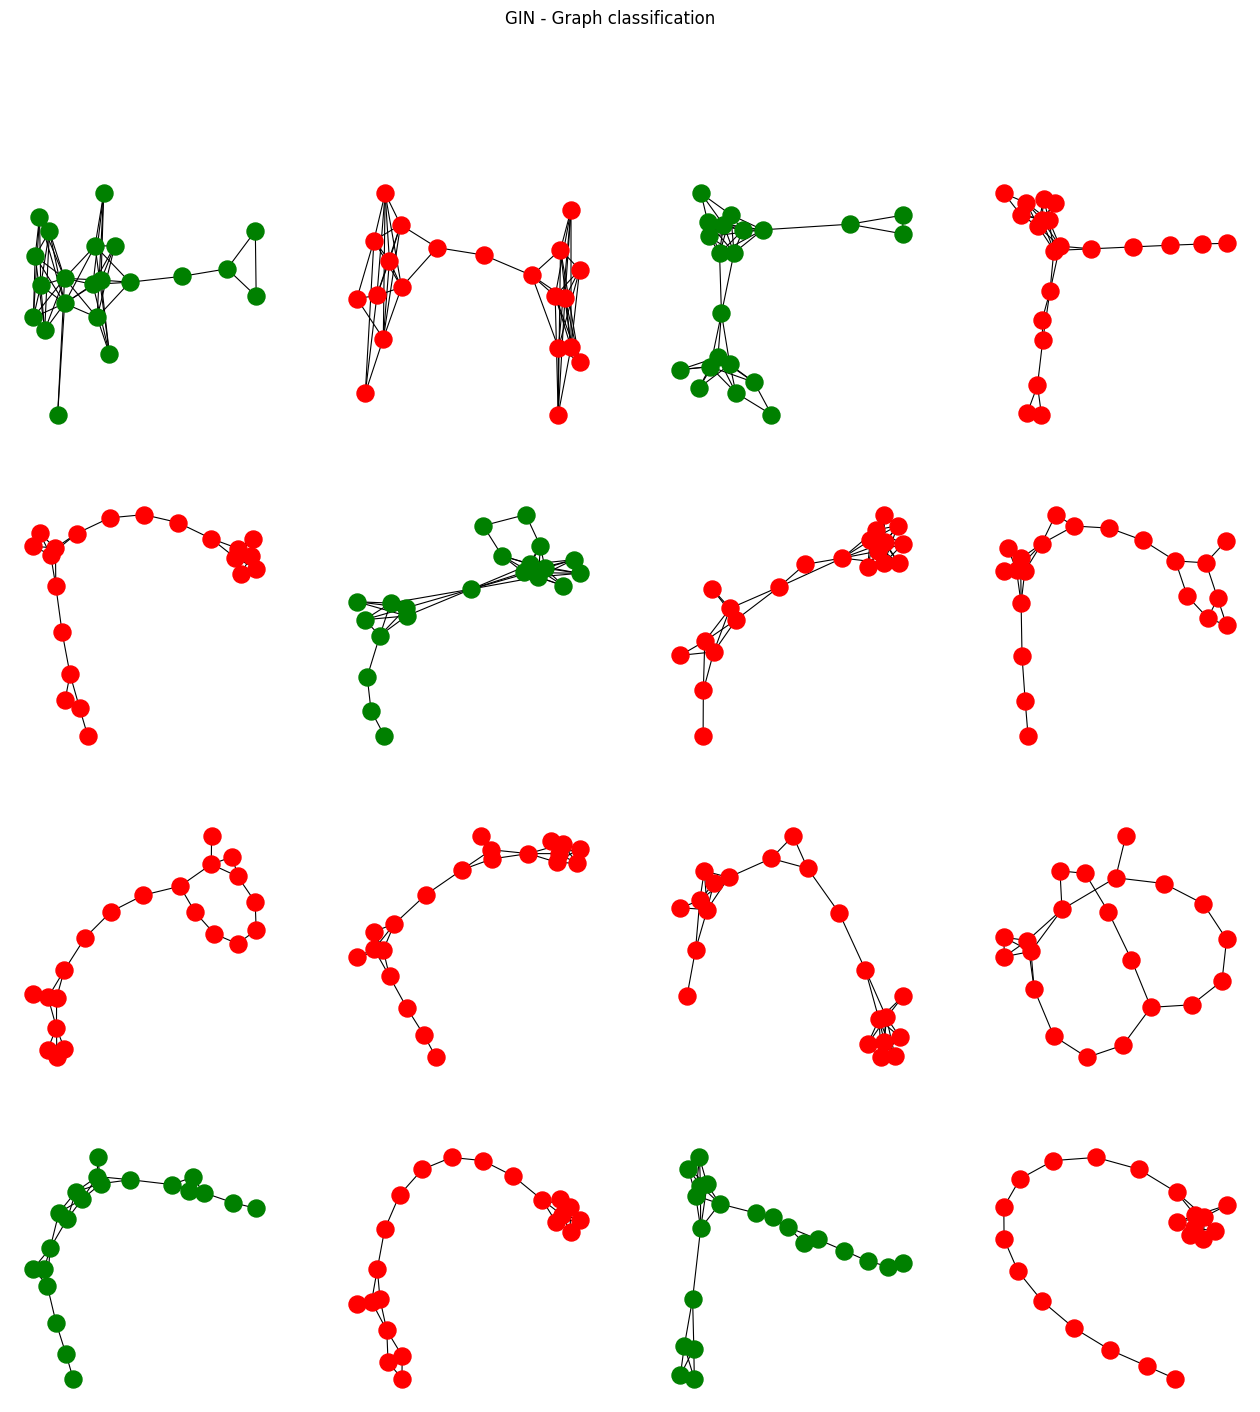

In [47]:
#plot GIN
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )


ValueError: index 16 is out of bounds for array with size 16

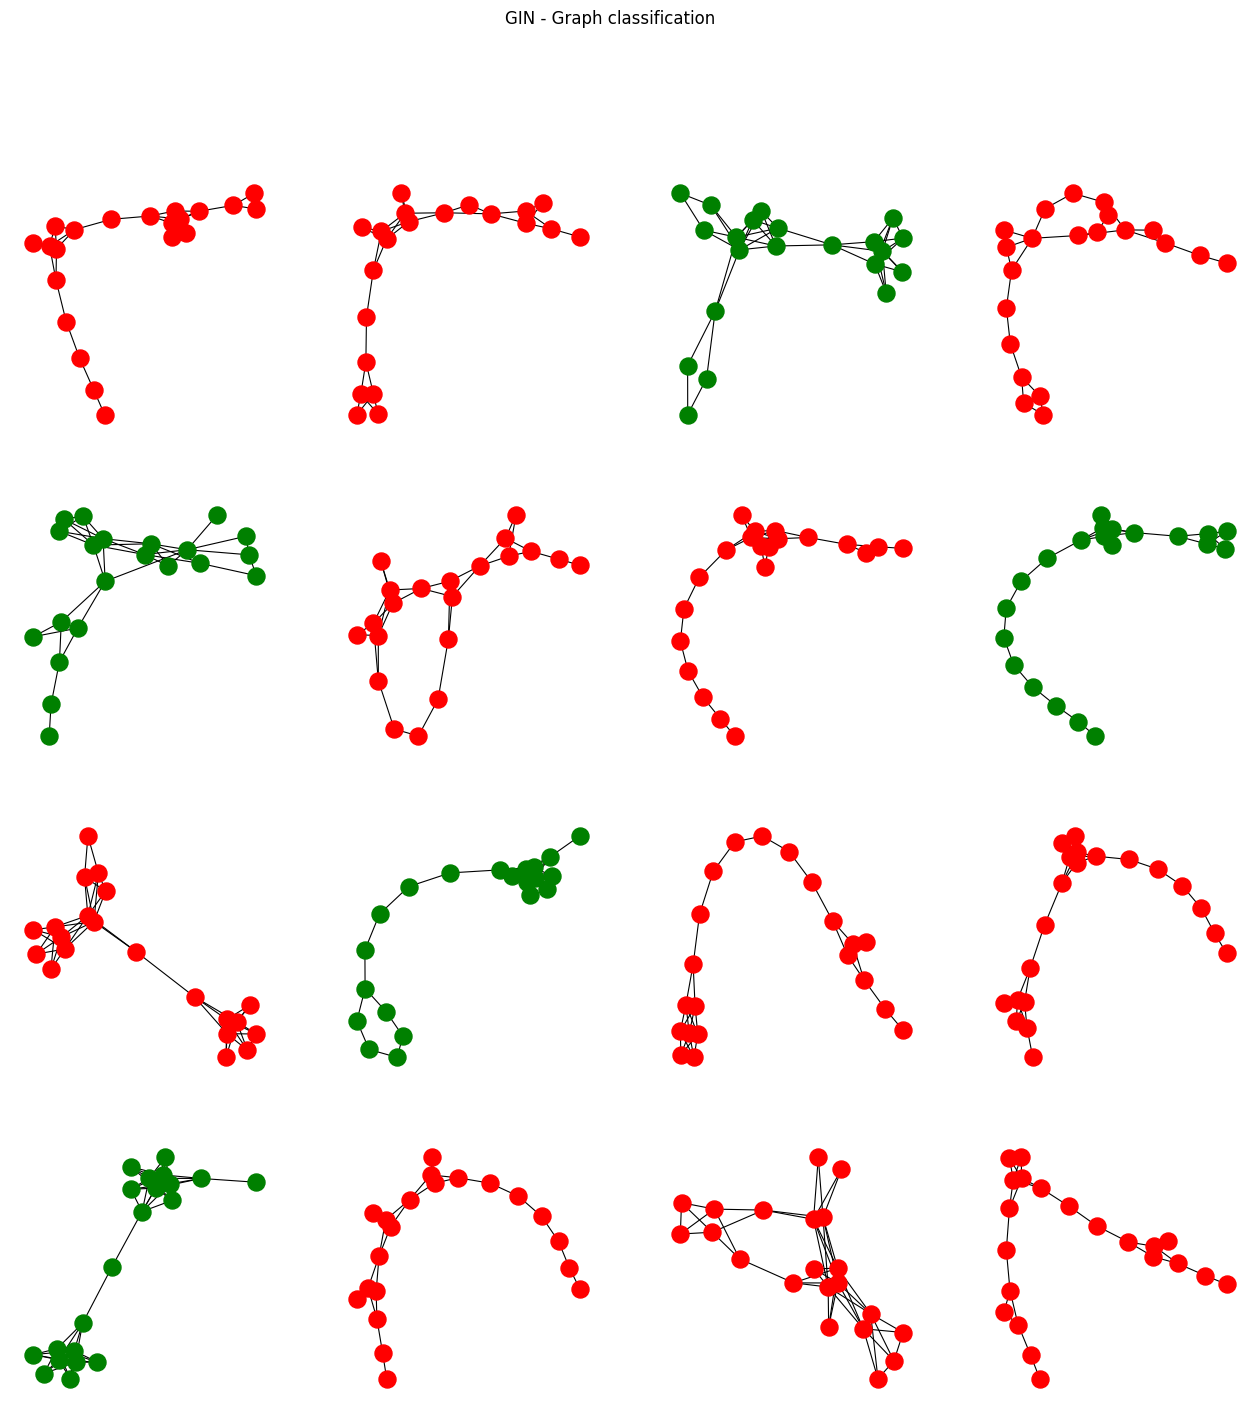

In [57]:
#sample output
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN - Graph classification')

for i, data in enumerate(dataset[174 - 32:174]):
    # Calculate color (green if correct, red otherwise)
    _, out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1).item() == data.y.item() else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, seed=0),
                     with_labels=False,
                     node_size=150,
                     node_color=color,
                     width=0.8,
                     ax=ax[ix]
                     )

plt.show()